# Read the data and rename some parameters
Ref: He et al., 2011, SIMULATING TRANSIENT CLIMATE EVOLUTION OF THE LAST DEGLACIATION WITH CCSM3

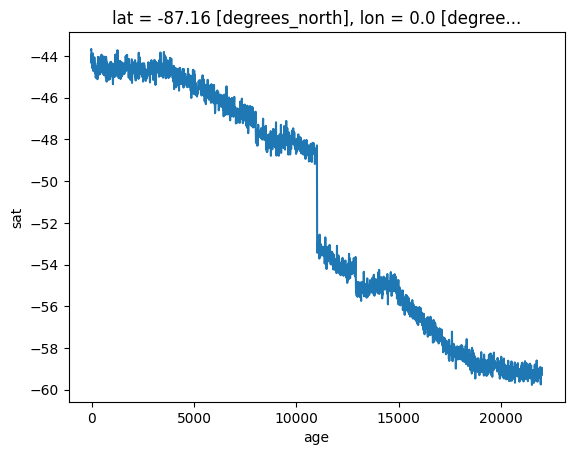

In [34]:
import xarray as xr

# import .nc data
ds = xr.open_dataset('D:\VScode\Last_deglaciation\TraCE_data\TraCE-21K-II.ann.TS.nc')
# ds

ds = ds.rename({'TS': 'sat'})
# rename the time to age
ds = ds.rename({'time': 'age'})
# multiply age by 1000
ds['age'] = ds['age'] * -1000

# convert the sat to degrees C
ds['sat'] = ds['sat'] - 273.15

ds = ds[['sat']]

# plot a record from the ds_sat at given lat and lon
ds['sat'].isel(lat=0, lon=0).plot()

# The age of LGMR data starts from 100 and ends at 23900 with step of 200 yr. The age of TraCE starts from -29 and ends at 22000, so we resample the TraCE data to match the resolution of LGMR

In [5]:
ds.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (age: 2204, lat: 48, lon: 96)
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * age      (age) float64 2.2e+04 2.199e+04 2.198e+04 ... -10.0 -20.0 -30.0
Data variables:
    sat      (age, lat, lon) float32 -57.14 -57.51 -57.91 ... -24.48 -24.36
Attributes:
    Conventions:               CF-1.0
    source:                    CAM
    case:                      b30.22_0kaDVT
    title:                     b30.22_0kaDVT b30.22_0kaDVT
    logname:                   fenghe
    host:                      phoenix
    Version:                   $Name: ccsm3_0_1_beta22 $
    revision_Id:               $Id: history.F90,v 1.26.2.48.4.1.4.1 2006/01/2...
    history:                   Sat Oct 26 04:30:38 2013: /glade/apps/opt/nco/...
    nco_openmp_thread_number:  1
    NCO:                       4.2.3>

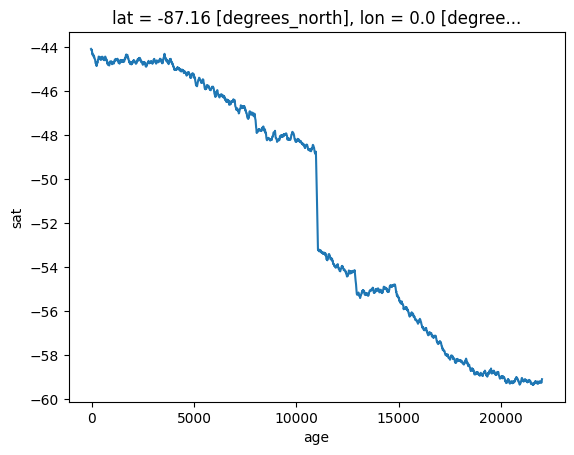

In [26]:
import numpy as np
import xarray as xr

# smoothed_sat = ds['sat'].rolling(age=10, center=True).mean()
smoothed_sat = ds['sat'].rolling(age=10, center=True, min_periods=1).mean()
ds_sat = smoothed_sat.to_dataset(name='sat')
ds_sat['sat'].isel(lat=0, lon=0).plot()

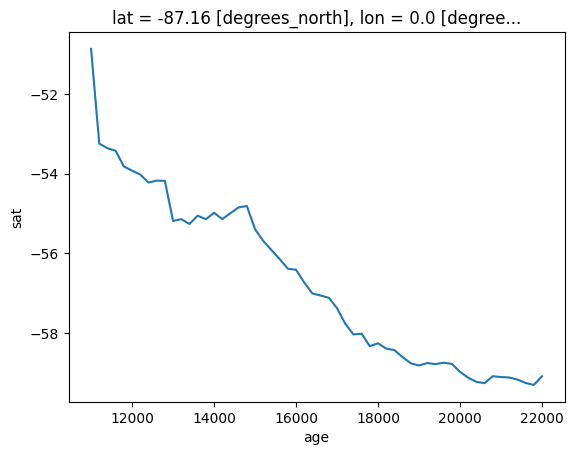

In [28]:
import numpy as np
import xarray as xr

# smoothed_sat = ds['sat'].rolling(age=10, center=True).mean()
smoothed_sat = ds['sat'].rolling(age=10, center=True, min_periods=1).mean()


# Ensure new_age is within the bounds of the original 'age' data
new_age = np.arange(11000, 22001, 200)

# Interpolate the smoothed 'sat' data variable to the new 'age' coordinate
resampled_sat = smoothed_sat.interp(age=new_age)
# resampled_sat=ds['sat'].interp(age=new_age, method='linear')


# Create a new xarray Dataset with the resampled 'sat' data variable
ds_sat = resampled_sat.to_dataset(name='sat')

# ds_sat
# plot a record from the ds_sat at given lat and lon
ds_sat['sat'].isel(lat=0, lon=0).plot()

# Alternative, don't resample data, just crop the data for age>11

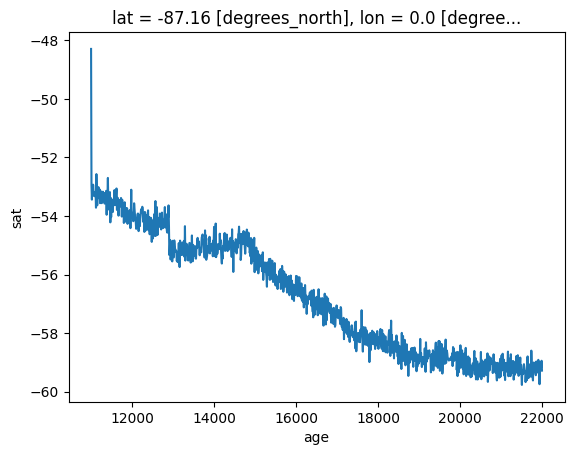

In [35]:
ds_sat=ds
ds_sat = ds_sat.where(ds_sat.age>=11000, drop=True)
ds_sat['sat'].isel(lat=0, lon=0).plot()

# PCA

shape of the weight: (48,)
shape of the reshaped sat_centered_weighted: (1101, 4608)


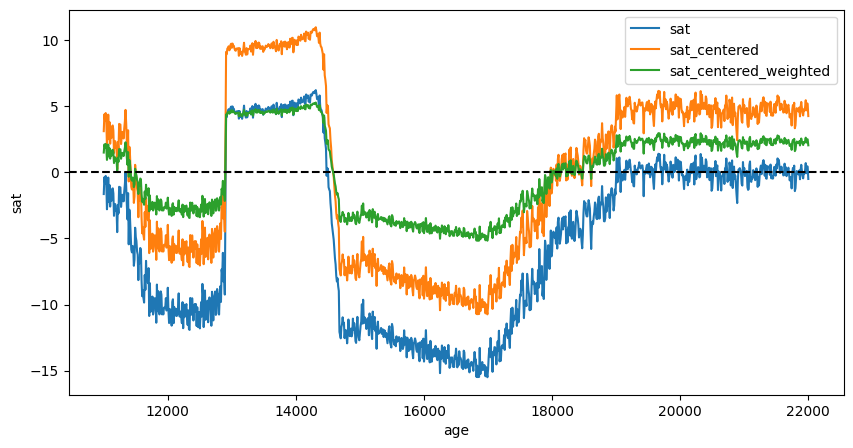

In [36]:
from toolbox import PCA_functions as pf
# 1. Center the Data
ds_sat = pf.center_data(ds_sat)

# 2. Weight the Data
ds_sat = pf.apply_weighting(ds_sat)

# 3. Plot the Centered and Weighted Data
# Assuming you want to plot data for lat=0 and lon=0
lat_index = 40
lon_index = 90
pf.plot_sat_variables(ds_sat, lat_index, lon_index)


In [37]:
from toolbox import PCA_functions as pf
# 4. Perform PCA
exp_variance, eofs, pcs = pf.sat_PCA(ds_sat)
print('Explained variance:', exp_variance)


shape of the reshaped sat_centered_weighted: (4608, 1101)
shape of u, s, vh: (4608, 4608) (1101,) (1101, 1101)
shape of EOFs: (4608, 2)
shape of PCs: (1101, 2)
Explained variance: [7.15307589e-01 2.04819739e-01 5.02440114e-02 ... 4.58561816e-08
 4.36330676e-08 2.38923658e-11]


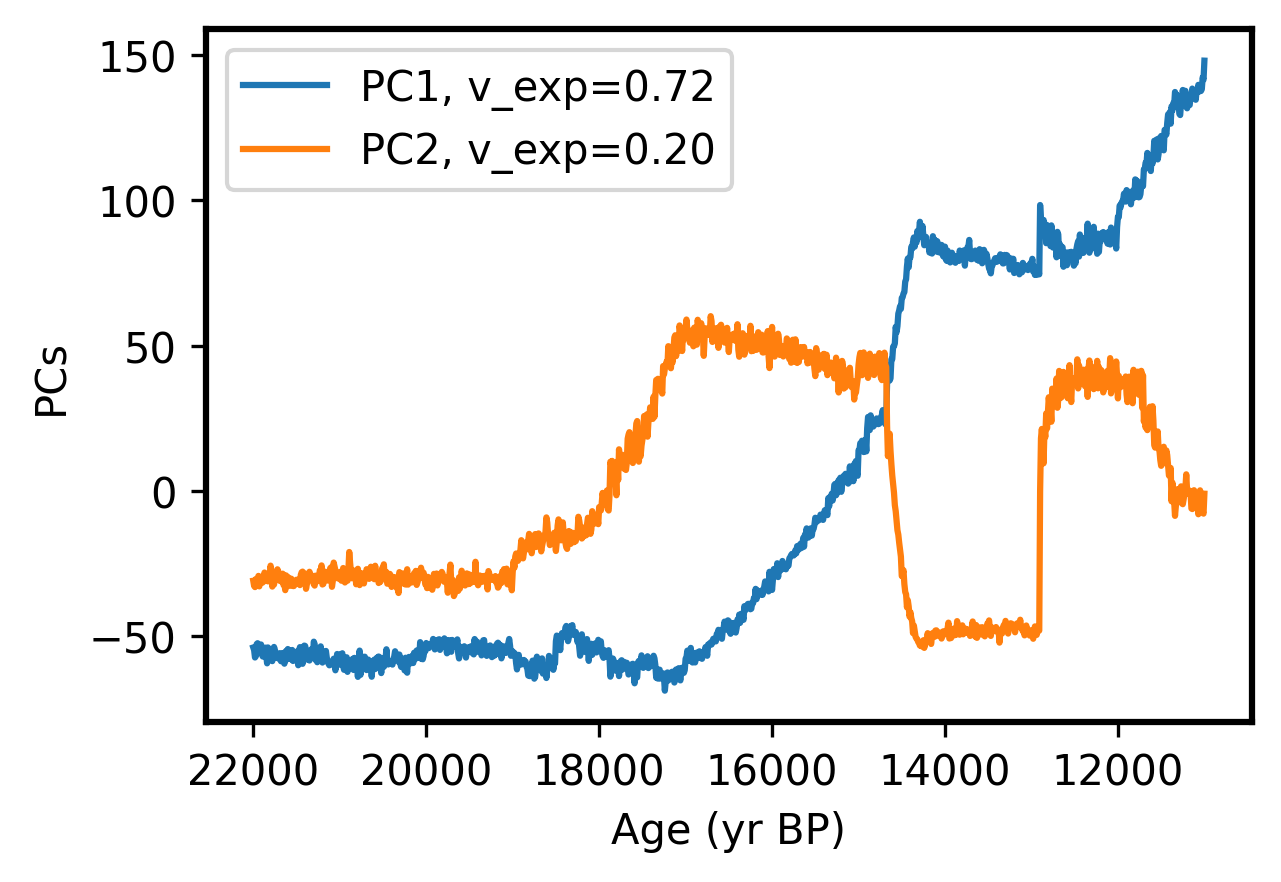

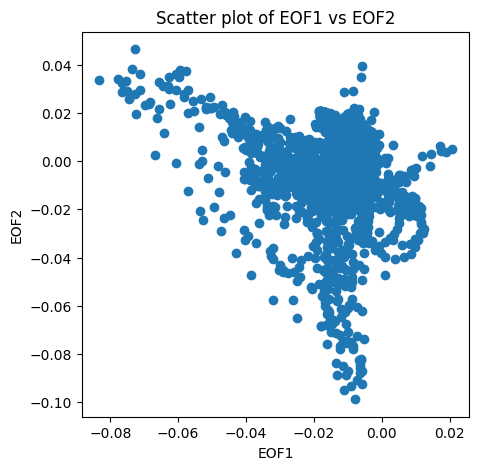

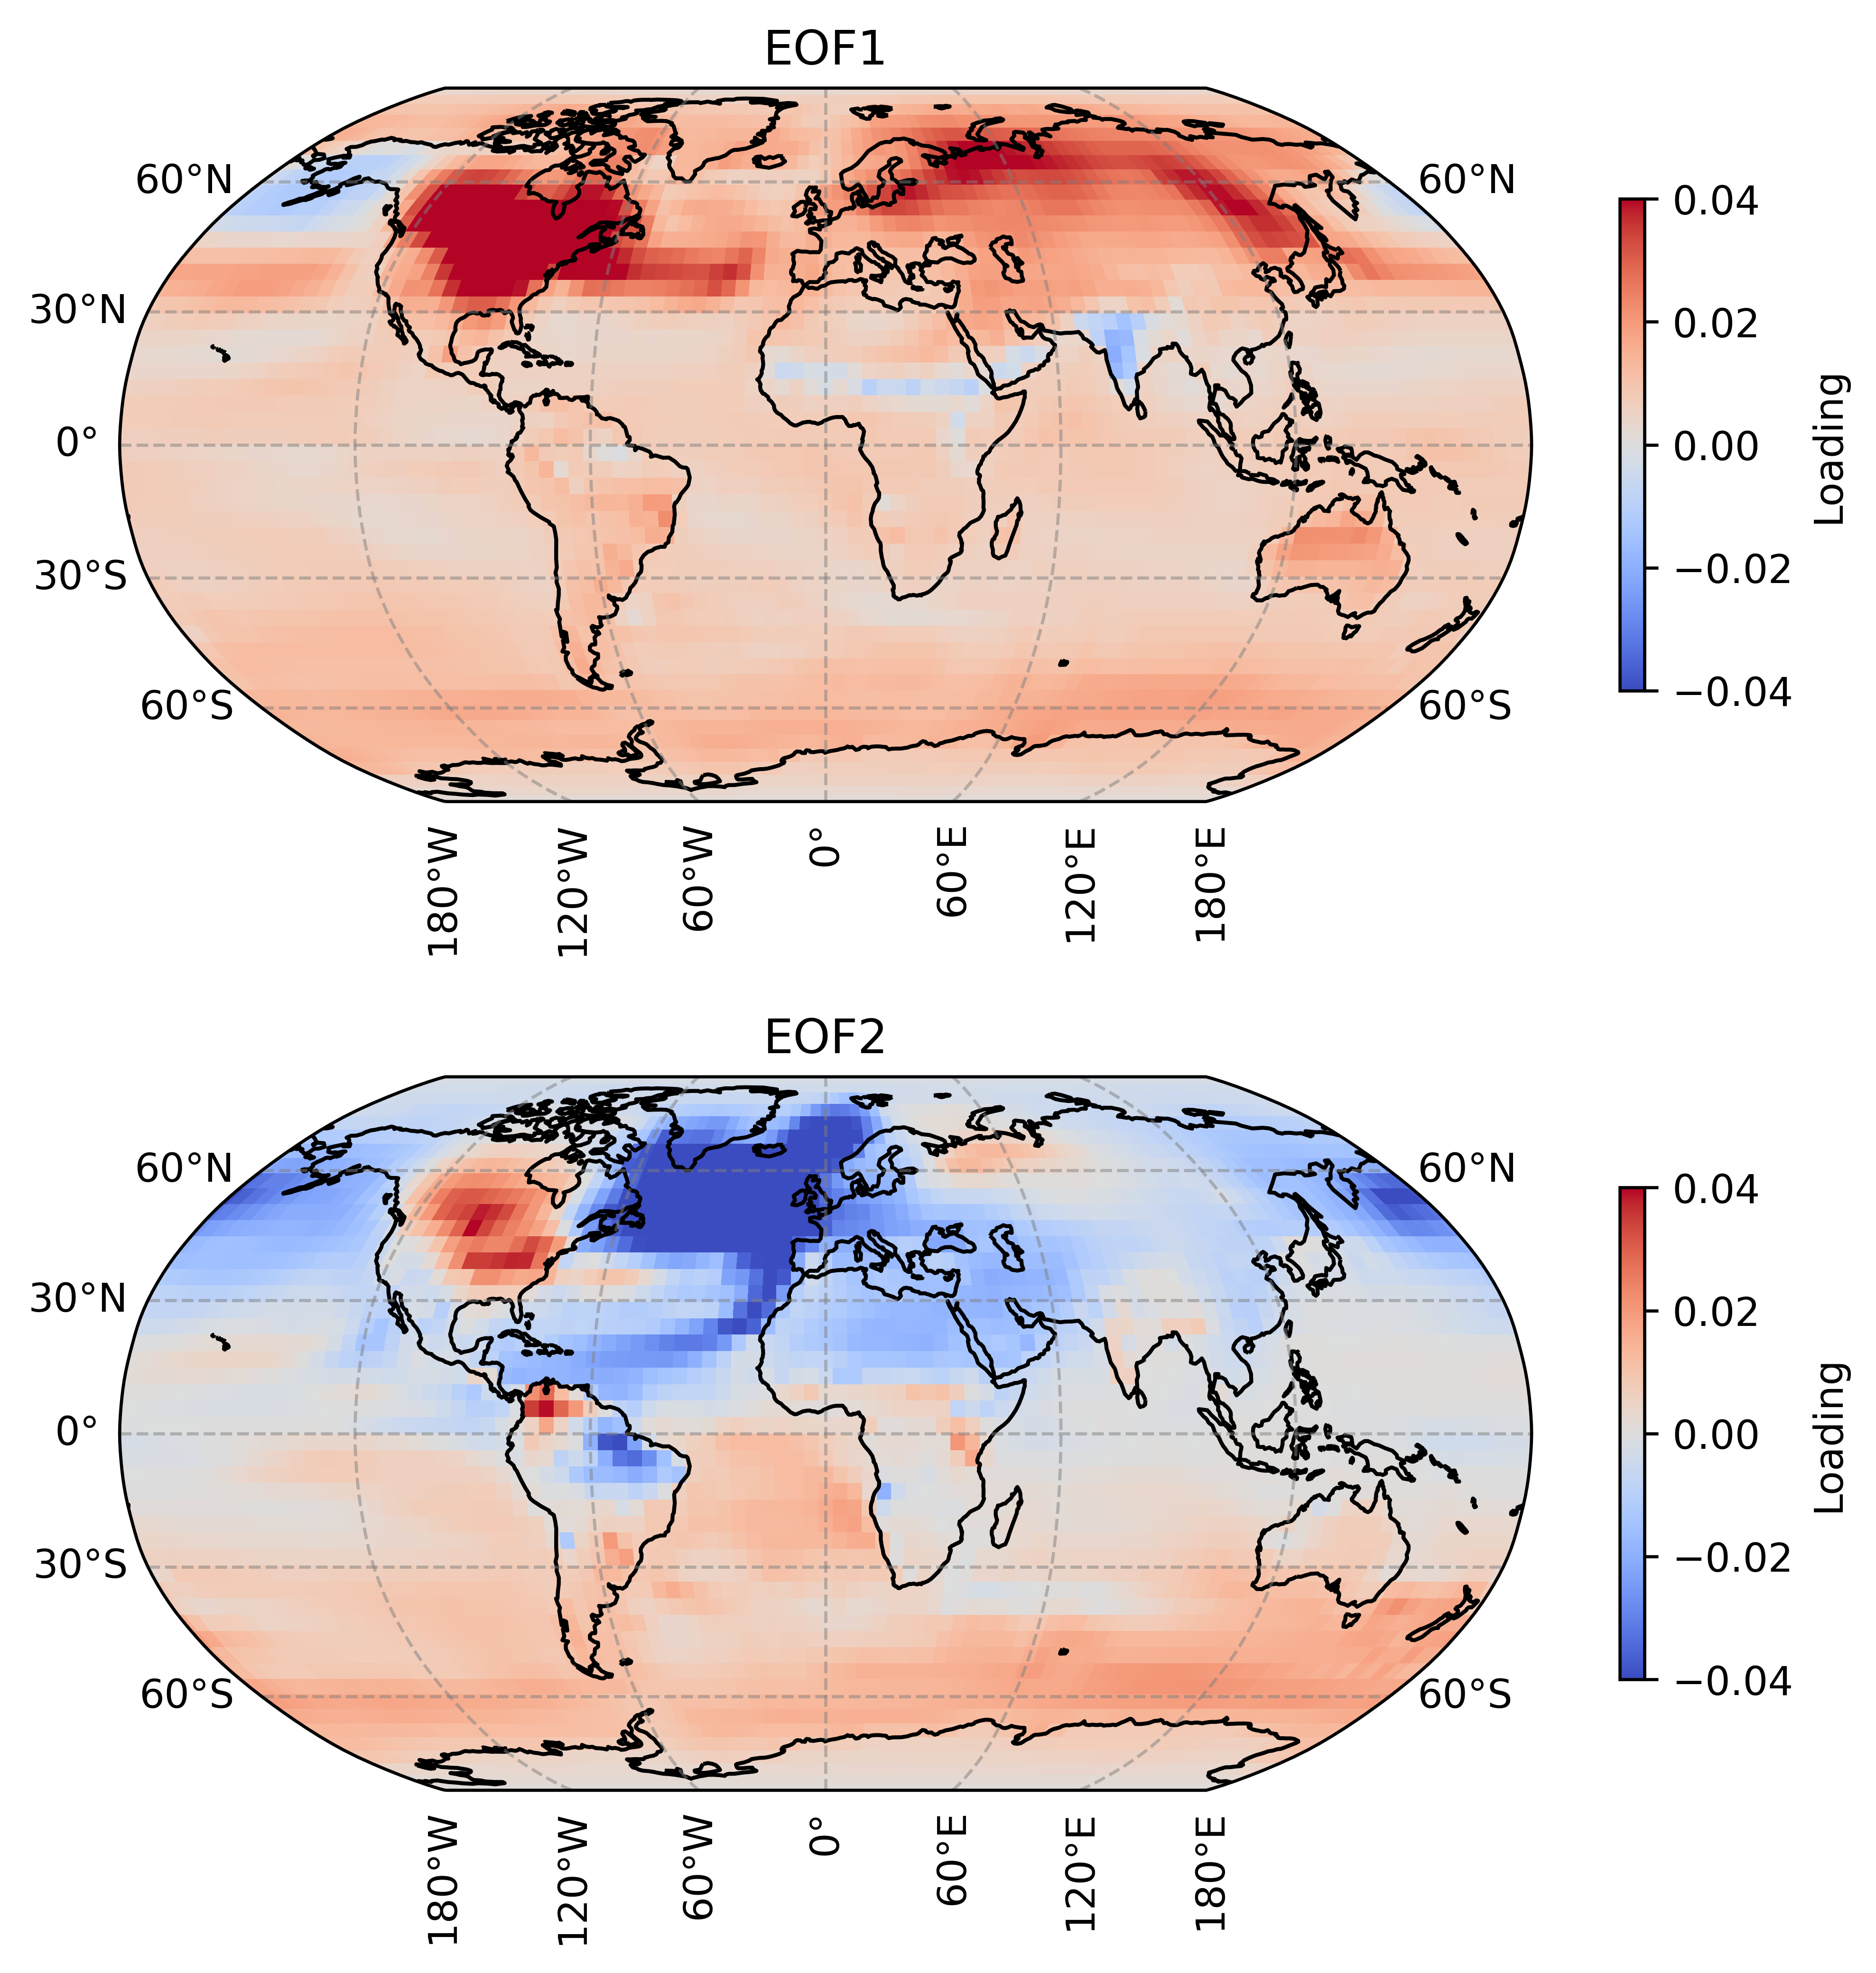

(<Figure size 4800x5400 with 4 Axes>,
 array([<GeoAxesSubplot: title={'center': 'EOF1'}>,
        <GeoAxesSubplot: title={'center': 'EOF2'}>], dtype=object))

In [38]:
# 5. Plot PCs
pf.plot_pcs(ds_sat['age'].values, pcs, exp_variance)

# 6. Plot EOF Scatter
pf.plot_eof_scatter(eofs)

# 7. Plot the EOF Map
pf.plot_eof_map(eofs, ds_sat['lat'].values, ds_sat['lon'].values)

# GMM

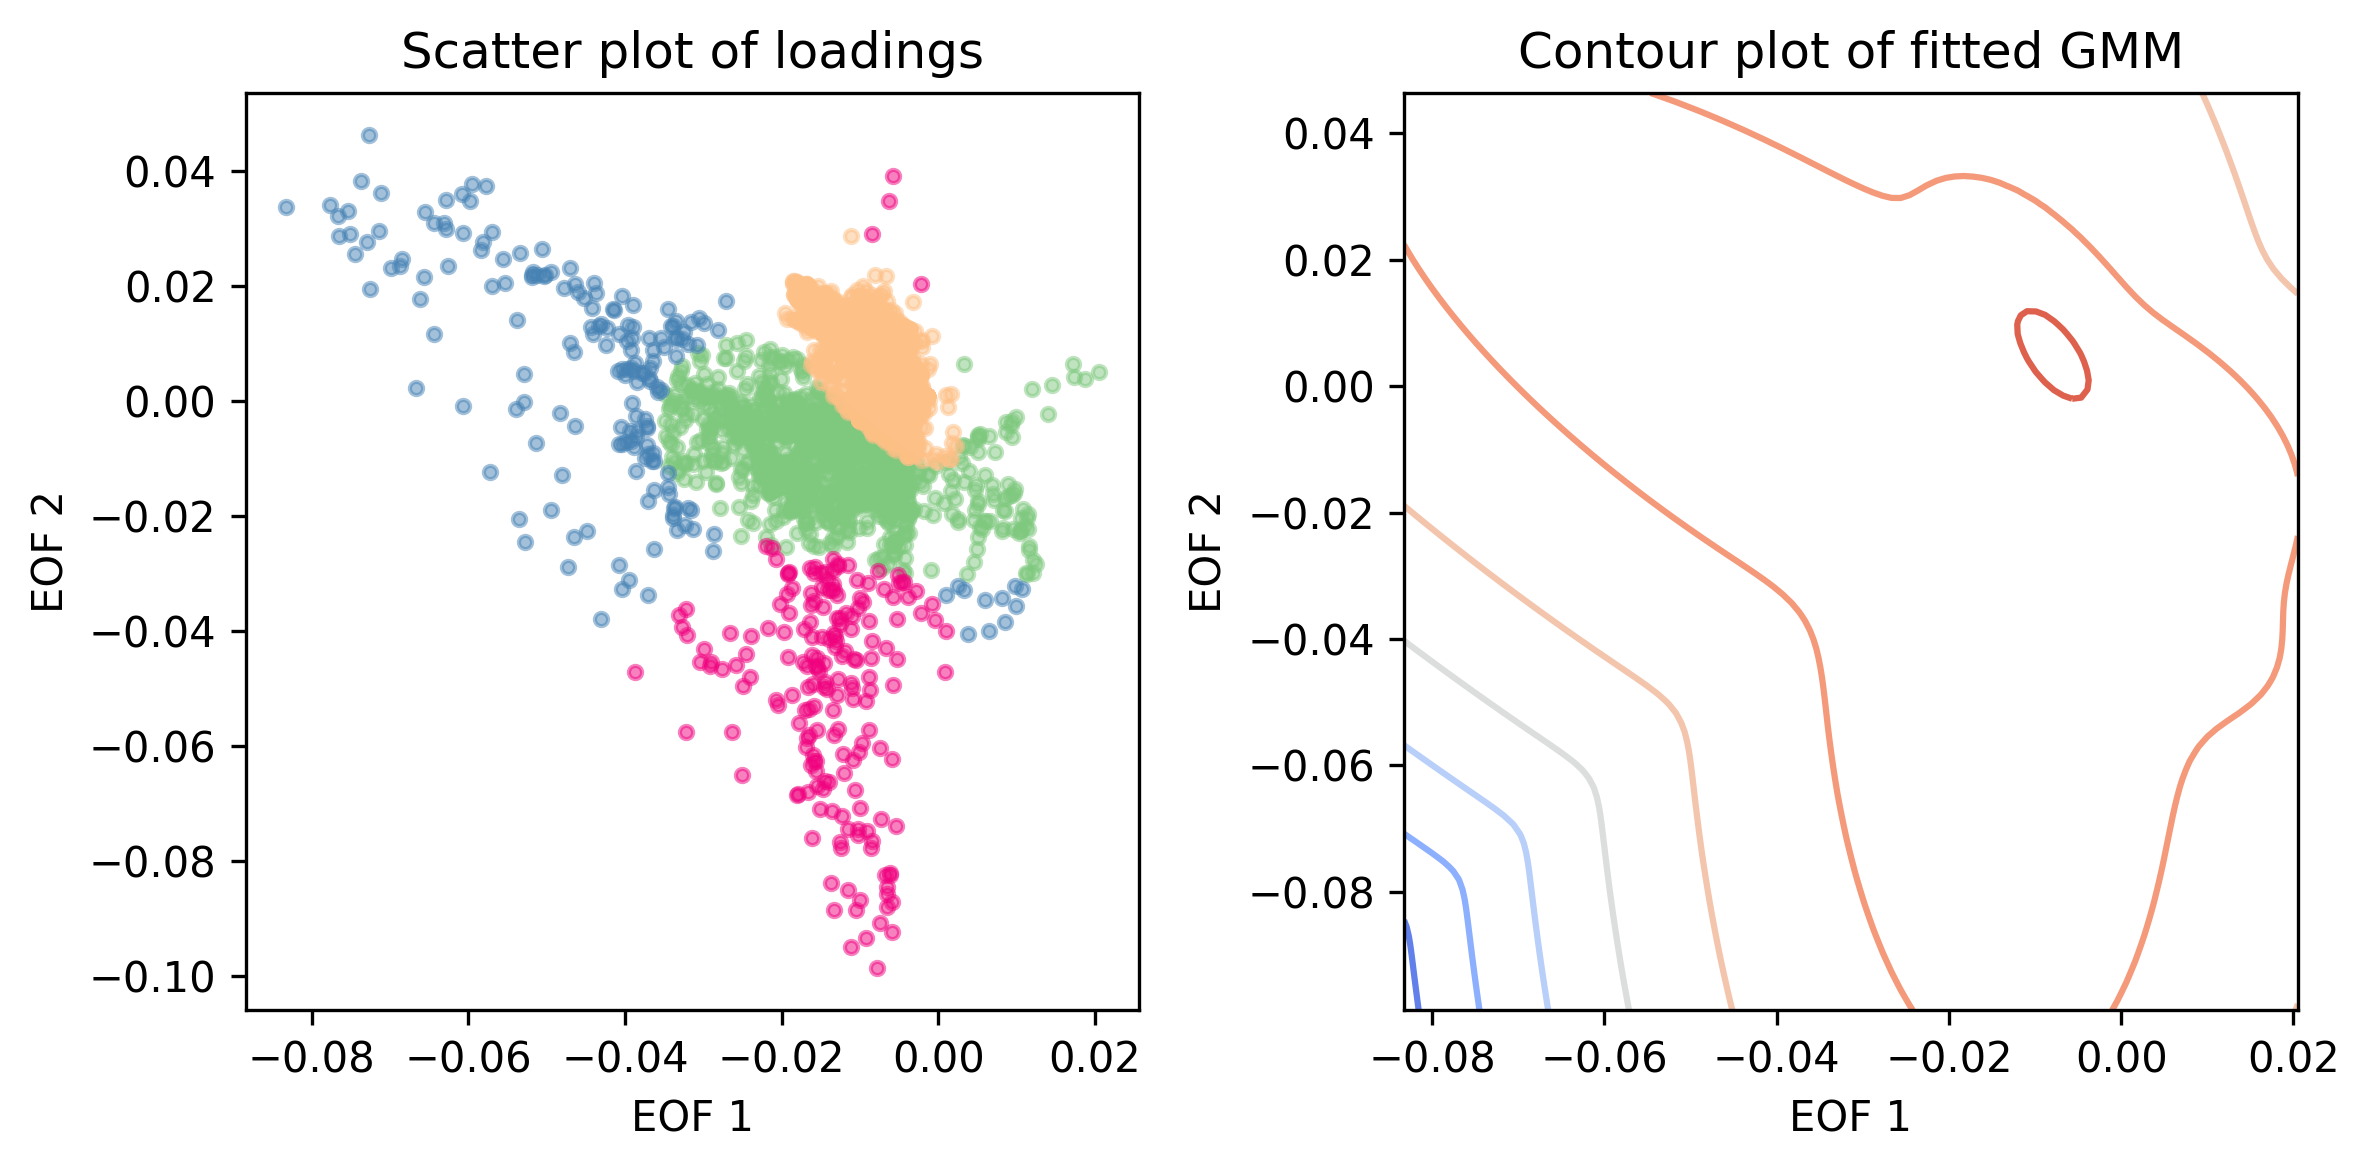

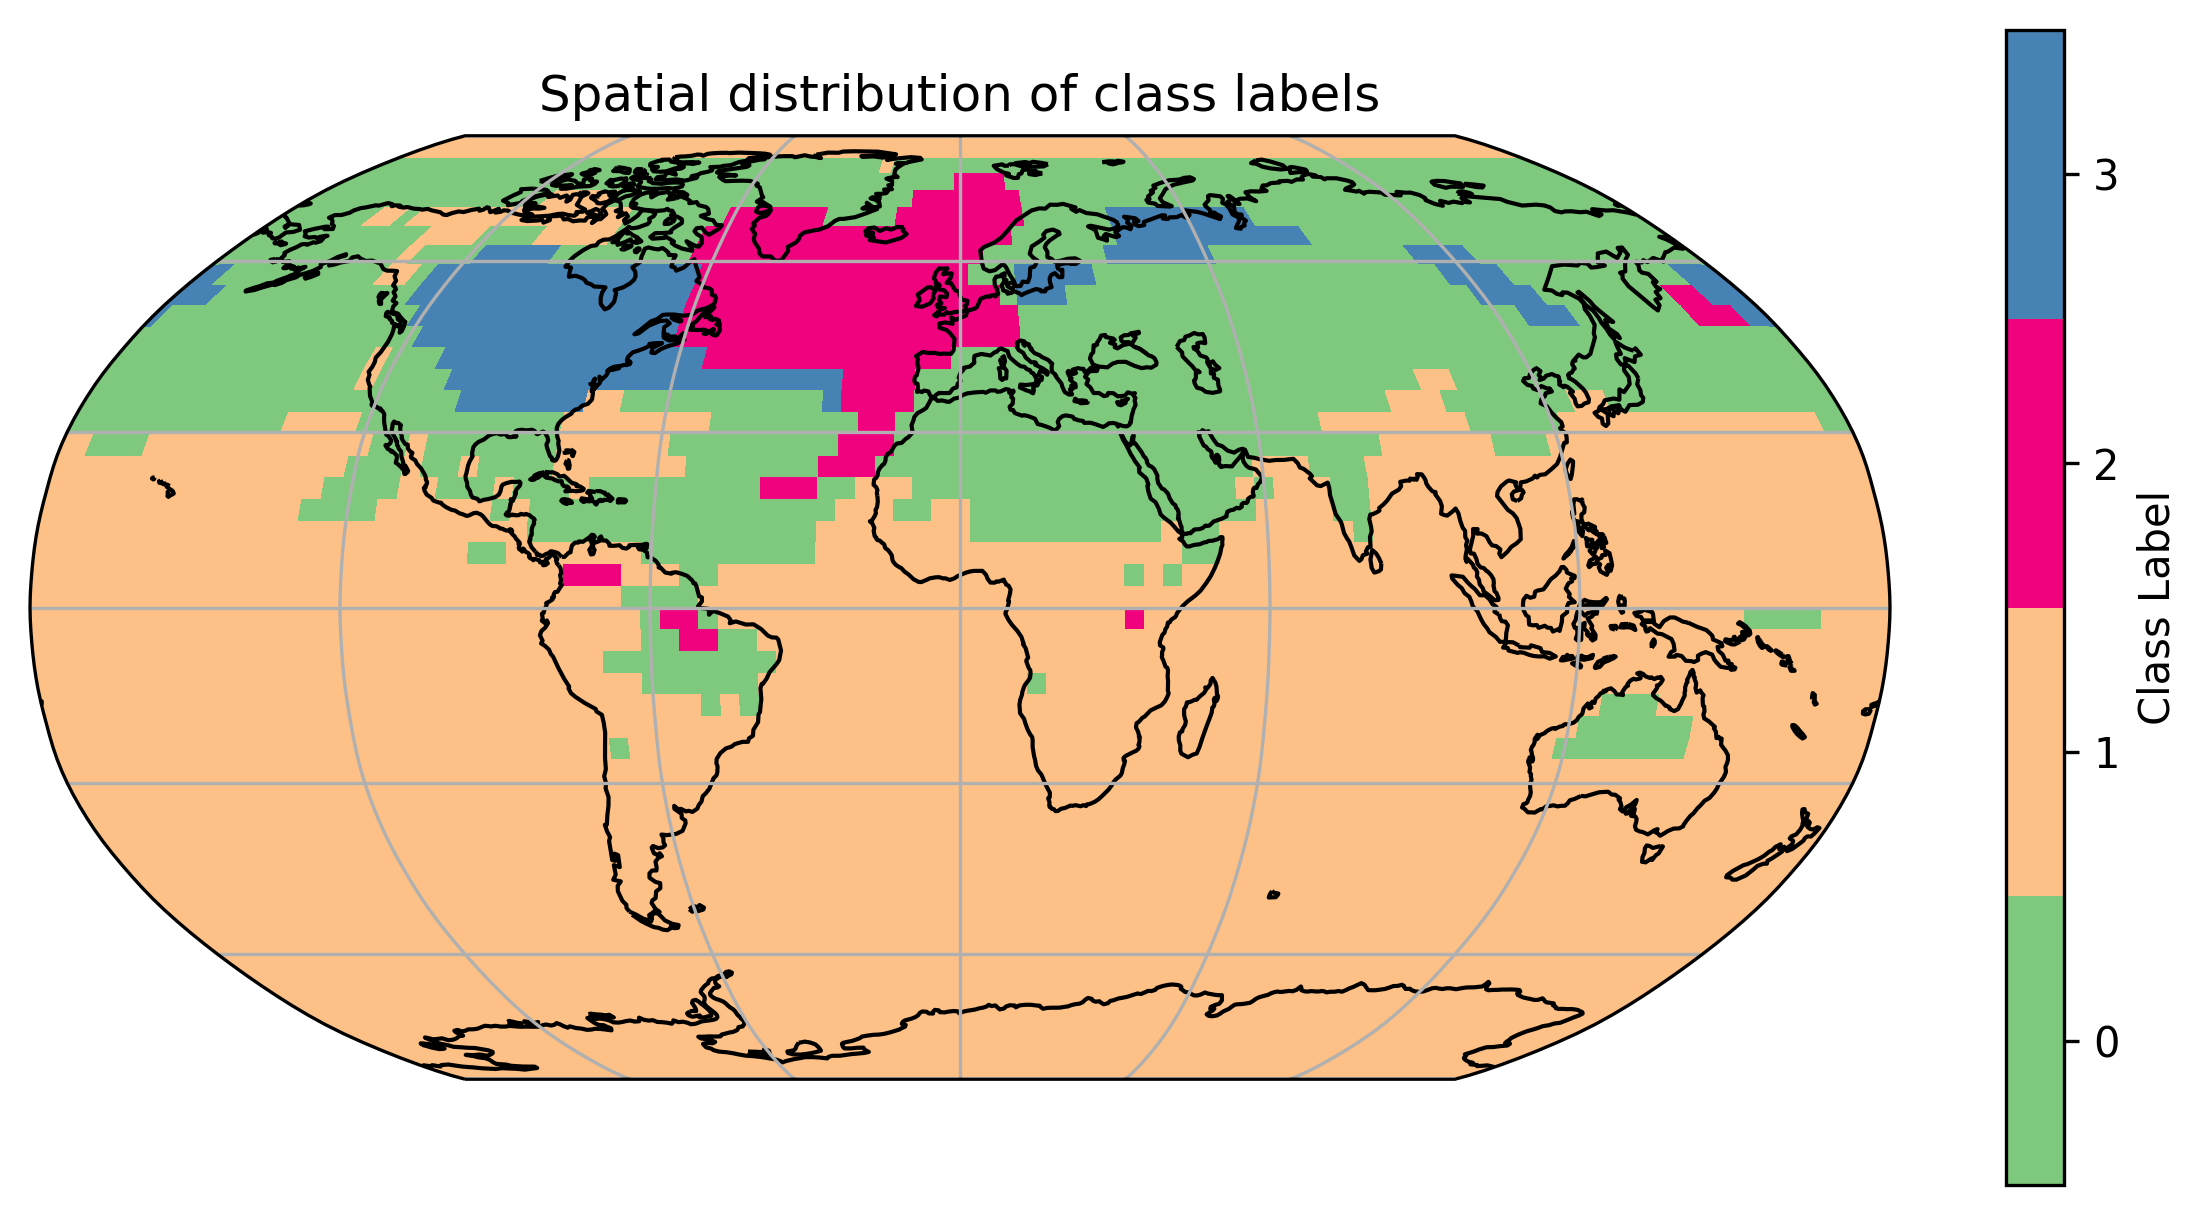

In [39]:
from toolbox import GMM_functions as gf
ds_EOFs_GMM,reshaped_probs=gf.GMM4EOFS(eofs, ds_sat,n_components=4)
gf.plot_labels(ds_EOFs_GMM)

In [40]:
from toolbox import GMM_functions as gf
import importlib
importlib.reload(gf)

uncor_weighted_avg=gf.plot_weighted_average_curve(ds_EOFs_GMM.copy(), dpi=900)